# N starvation 

## Which N sources allow HOT1A3 to grow

check out Escher visualization https://escher.readthedocs.io/en/latest/getting_started.html

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import numpy as np
import seaborn as sns
import itertools
from matplotlib.colors import LogNorm, Normalize


In [2]:
import subprocess
import time


In [3]:
from cobra.flux_analysis import flux_variability_analysis
from cobra.flux_analysis import production_envelope


In [4]:
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)

In [5]:
sns.hls_palette

<function seaborn.palettes.hls_palette(n_colors=6, h=0.01, l=0.6, s=0.65, as_cmap=False)>

In [6]:
def get_elements(rid):
    r = model.reactions.get_by_id(rid)
    m = r.reactants[0]    
    elements = m.elements.copy()
    
    res = {
        'reaction' : rid,
        'metabolite' : m.name,
        'mid' : m.id,
        'N' : 'N' in elements,
        'C' : 'C' in elements,
        
    }
    return pd.Series(res)

# Some compound data

In [49]:
#fpath = '~/work/tools//ModelSEEDDatabase/Biochemistry/compounds.tsv'
fpath = '../../ModelSEEDDatabase/Biochemistry/compounds.tsv'
ref_df = pd.read_csv(fpath, sep='\t')

C:\Users\Osnat\AppData\Local\Temp\ipykernel_15280\3248102979.py:3: DtypeWarning: Columns (4,10) have mixed types. Specify dtype option on import or set low_memory=False.
  ref_df = pd.read_csv(fpath, sep='\t')


In [50]:
kegg_compound_df = pd.read_csv('../../CC1A3/genomes/KEGG/kegg_compounds.csv', )


In [51]:
ref_df['BiggID'] = ref_df.aliases.str.extract(r'BiGG: ([^;\|\:]+)')
ref_df = ref_df.loc[ref_df.source.isin(['Primary Database'])]
ref_df['kegg_id'] = ref_df.aliases.str.extract(r'KEGG: ([^;\|\:]+)')

In [52]:
ref_df = pd.merge(ref_df, kegg_compound_df, left_on='kegg_id', right_on='compound_id', how='left')

# Import model and manipulate based on Ofaim at el

In [7]:
import os
model_dpath = os.path.join('..', 'Models')
model_fname = 'HOT1A3_ncbi.xml'
model_fpath = os.path.join(model_dpath, model_fname)


In [8]:
model = cobra.io.read_sbml_model(model_fpath)

In [9]:
exchange_ids = [r.id for r in model.exchanges] # + ["R00024"]

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [10]:
print('reactions', len(model.reactions))
print('metabolites', len(model.metabolites))
print('genes', len(model.genes))

reactions 2341
metabolites 1546
genes 1025


In [11]:
model

Name,HOT1A3_ncbi
Memory address,1ae8aedec70
Number of metabolites,1546
Number of reactions,2341
Number of genes,1025
Number of groups,0
Objective expression,1.0*Growth - 1.0*Growth_reverse_699ae
Compartments,"cytosol, periplasm, extracellular space"


In [12]:
cobra.Configuration()

Attribute,Description,Value
solver,Mathematical optimization solver,glpk
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,5
cache_directory,Path for the model cache,C:\Users\Osnat\AppData\Local\opencobra\cobrapy\Cache
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


In [13]:
exchange_ids

['EX_12ppd__R_e',
 'EX_12ppd__S_e',
 'EX_14glucan_e',
 'EX_15dap_e',
 'EX_25dkglcn_e',
 'EX_2ameph_e',
 'EX_2m35mdntha_e',
 'EX_35dnta_e',
 'EX_3h4atb_e',
 'EX_3mb_e',
 'EX_4hba_e',
 'EX_4hbald_e',
 'EX_4hbz_e',
 'EX_5dglcn_e',
 'EX_5drib_e',
 'EX_6atha_e',
 'EX_LalaLglu_e',
 'EX_abg4_e',
 'EX_abt_e',
 'EX_ac_e',
 'EX_acac_e',
 'EX_acald_e',
 'EX_acgam_e',
 'EX_actn__R_e',
 'EX_ade_e',
 'EX_adn_e',
 'EX_ala_L_asp__L_e',
 'EX_ala_L_glu__L_e',
 'EX_ala_L_thr__L_e',
 'EX_ala__D_e',
 'EX_ala__L_e',
 'EX_ala_gln_e',
 'EX_ala_his_e',
 'EX_ala_leu_e',
 'EX_alagly_e',
 'EX_alahis_e',
 'EX_alaleu_e',
 'EX_alathr_e',
 'EX_alatrp_e',
 'EX_alltn_e',
 'EX_arab__L_e',
 'EX_arbt6p_e',
 'EX_arbt_e',
 'EX_arg__L_e',
 'EX_asn__L_e',
 'EX_aso3_e',
 'EX_aso4_e',
 'EX_asp__L_e',
 'EX_bhb_e',
 'EX_btn_e',
 'EX_but_e',
 'EX_bz_e',
 'EX_ca2_e',
 'EX_cell4_e',
 'EX_cellb_e',
 'EX_cgly_e',
 'EX_chol_e',
 'EX_cinnm_e',
 'EX_cit_e',
 'EX_cl_e',
 'EX_co2_e',
 'EX_co_e',
 'EX_cobalt2_e',
 'EX_crn_e',
 'EX_csn_e',
 

In [14]:
model.reactions.get_by_id('EX_cyan_e')

Reaction identifier,EX_cyan_e
Name,R_EX_cyan_e
Memory address,0x1ae9785ab50
Stoichiometry,cyan_e <=> Hydrogen cyanide <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [15]:
model.reactions.get_by_id('Growth')

Reaction identifier,Growth
Name,Biomass reaction
Memory address,0x1ae978e0e50
Stoichiometry,0.000223 10fthf_c + 0.513689 ala__L_c + 0.000223 amet_c + 0.295792 arg__L_c + 0.241055 asn__L_c + 0.241055 asp__L_c + 54.124831 atp_c + 0.005205 ca2_c + 0.005205 cl_c + 0.000576 coa_c + 0.0001... 0.000223 10-Formyltetrahydrofolate + 0.513689 L-Alanine + 0.000223 S-Adenosyl-L-methionine + 0.295792 L-Arginine + 0.241055 L-Asparagine + 0.241055 L-Aspartate + 54.124831 ATP C10H12N5O13P3 +...
GPR,
Lower bound,0.0
Upper bound,1000.0


# Identify N sources where MED4 grows on

In [16]:
len(model.medium)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


238

In [17]:
len(exchange_ids)

238

In [18]:
# copied from MED4 model
pro99_mediums = ['Ammonia', 'Cadmium', 'Ca2+', 'Cl-', 'Cobalt ion', 'Copper',
       'Orthophosphate', 'H2O', 'HCO3-', 'H+', 'Fe2+', 'Photon',
       'Magnesium cation', 'Molybdenum', 'O2', 'K+', 'Selenate', 'Na+',
       'Strontium cation', 'Sulfate', 'Zn2+', 'Hydrogen peroxide']
print('\n'.join(pro99_mediums))

Ammonia
Cadmium
Ca2+
Cl-
Cobalt ion
Copper
Orthophosphate
H2O
HCO3-
H+
Fe2+
Photon
Magnesium cation
Molybdenum
O2
K+
Selenate
Na+
Strontium cation
Sulfate
Zn2+
Hydrogen peroxide


In [19]:
# what are the metabolites in the medium?
df_medium = pd.DataFrame({'mediumExchange' : model.medium.keys()})
df_medium = pd.DataFrame.from_records(df_medium.mediumExchange.apply(get_elements))


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [20]:
df_medium

,reaction,metabolite,mid,N,C
0,EX_12ppd__R_e,"(R)-Propane-1,2-diol",12ppd__R_e,False,True
1,EX_12ppd__S_e,"(S)-Propane-1,2-diol",12ppd__S_e,False,True
2,EX_14glucan_e,"1,4-alpha-D-glucan",14glucan_e,False,True
3,EX_15dap_e,"1,5-Diaminopentane",15dap_e,True,True
4,EX_25dkglcn_e,"2,5-diketo-D-gluconate",25dkglcn_e,False,True
...,...,...,...,...,...
233,EX_val__L_e,L-Valine,val__L_e,True,True
234,EX_xan_e,Xanthine,xan_e,True,True
235,EX_xtsn_e,Xanthosine,xtsn_e,True,True
236,EX_xyl__D_e,D-Xylose,xyl__D_e,False,True


In [21]:
pro99_df = pd.read_excel('HOT1A3_medium.xlsx')

In [22]:
pro99_df.head()

,reaction,metabolite,N,C,pro99,MED4 metabolite,promm
0,EX_actn__R_e,R Acetoin C4H8O2,False,True,NaN,NaN,NaN
1,EX_bhb_e,(R)-3-Hydroxybutanoate,False,True,NaN,NaN,NaN
2,EX_12ppd__R_e,"(R)-Propane-1,2-diol",False,True,NaN,NaN,NaN
3,EX_12ppd__S_e,"(S)-Propane-1,2-diol",False,True,NaN,NaN,NaN
4,EX_phedca_e,10 Phenyldecanoic acid,False,True,NaN,NaN,NaN


In [23]:
df_medium.loc[df_medium.metabolite.str.contains('ic')]

,reaction,metabolite,mid,N,C
8,EX_3h4atb_e,3 Hydroxy 4 acetylthiobutanoic acid,3h4atb_e,False,False
9,EX_3mb_e,3-Methylbutanoic acid,3mb_e,False,True
15,EX_6atha_e,6 acetylthiohexanoic acid,6atha_e,False,True
84,EX_fe3dcit_e,Fe(III)dicitrate,fe3dcit_e,False,True
85,EX_fe3pyovd_kt_e,Ferrypyoverdine P putida KT2440 specific,fe3pyovd_kt_e,True,True
154,EX_lnlc_e,Linoleic acid (all cis C18:2) n-6,lnlc_e,False,True
182,EX_phedca_e,10 Phenyldecanoic acid,phedca_e,False,True
183,EX_phehpa_e,7 Phenylheptanoic acid,phehpa_e,False,True
184,EX_phehxa_e,6 Phenylhexanoic acid,phehxa_e,False,True
186,EX_phenona_e,9 Phenylnonanoic acid,phenona_e,False,True


In [24]:
pro99_df.loc[~pro99_df.reaction.isin(exchange_ids)]

,reaction,metabolite,N,C,pro99,MED4 metabolite,promm
12,EX_4abut_e,4-Aminobutanoate,True,True,NaN,NaN,NaN
42,EX_btoh_e,Butanol,False,True,NaN,NaN,NaN
47,EX_chor_e,Chorismate,False,True,NaN,NaN,NaN
53,EX_alaala_e,D-Alanyl-D-alanine,True,True,NaN,NaN,NaN
70,EX_glcn_e,D-Gluconate,False,True,NaN,NaN,NaN
82,EX_ser__D_e,D-Serine,True,True,NaN,NaN,NaN
125,EX_id3acald_e,Indole 3 acetaldehyde C10H9NO,True,True,NaN,NaN,NaN
144,EX_metox_e,L Methionine S oxide C5H11NO3S,True,True,NaN,NaN,NaN
160,EX_his__L_e,L-Histidine,True,True,NaN,NaN,NaN
168,EX_phe__L_e,L-Phenylalanine,True,True,NaN,NaN,NaN


In [25]:
pro99_df.loc[~pro99_df.reaction.isin(exchange_ids), 'promm'] = np.NaN

In [26]:
promm_exchanges = pro99_df.loc[pro99_df.pro99.isin(['yes']) | pro99_df.promm.isin(['yes']), 'reaction']
pro99_exchanges = pro99_df.loc[pro99_df.pro99.isin(['yes']), 'reaction']
other_exchahges = [m for m in exchange_ids if m not in promm_exchanges]

In [27]:
#[m for m in exchange_ids if m not in pro99_df.reaction.values]
df_medium.loc[~df_medium.reaction.isin(pro99_df.reaction), ['reaction', 'metabolite']]

,reaction,metabolite
2,EX_14glucan_e,"1,4-alpha-D-glucan"
3,EX_15dap_e,"1,5-Diaminopentane"
53,EX_cell4_e,Cellulose (n=4 repeating units)
90,EX_fuc_e,L-fuculose
137,EX_hom__L_e,L-Homoserine
141,EX_ibt_e,Isobutyrate
167,EX_mnl1p_e,D-Mannitol 1-phosphate
170,EX_mththf_e,"(2R,4S)-2-methyl-2,3,3,4-tetrahydroxytetrahydr..."
201,EX_quin_e,Quinate
205,EX_salchs4_e,Salmochelin-S4


In [28]:
#[m for m in exchange_ids if m not in pro99_df.reaction.values]
pro99_df.loc[~pro99_df.reaction.isin(df_medium.reaction), ['reaction', 'metabolite']]

,reaction,metabolite
12,EX_4abut_e,4-Aminobutanoate
42,EX_btoh_e,Butanol
47,EX_chor_e,Chorismate
53,EX_alaala_e,D-Alanyl-D-alanine
70,EX_glcn_e,D-Gluconate
82,EX_ser__D_e,D-Serine
125,EX_id3acald_e,Indole 3 acetaldehyde C10H9NO
144,EX_metox_e,L Methionine S oxide C5H11NO3S
160,EX_his__L_e,L-Histidine
168,EX_phe__L_e,L-Phenylalanine


In [29]:
pro99_df.head()

,reaction,metabolite,N,C,pro99,MED4 metabolite,promm
0,EX_actn__R_e,R Acetoin C4H8O2,False,True,NaN,NaN,NaN
1,EX_bhb_e,(R)-3-Hydroxybutanoate,False,True,NaN,NaN,NaN
2,EX_12ppd__R_e,"(R)-Propane-1,2-diol",False,True,NaN,NaN,NaN
3,EX_12ppd__S_e,"(S)-Propane-1,2-diol",False,True,NaN,NaN,NaN
4,EX_phedca_e,10 Phenyldecanoic acid,False,True,NaN,NaN,NaN


In [30]:
pro99_df.columns

Index(['reaction', 'metabolite', 'N', 'C', 'pro99', 'MED4 metabolite',
       'promm'],
      dtype='object')

In [31]:
df_medium.head()

,reaction,metabolite,mid,N,C
0,EX_12ppd__R_e,"(R)-Propane-1,2-diol",12ppd__R_e,False,True
1,EX_12ppd__S_e,"(S)-Propane-1,2-diol",12ppd__S_e,False,True
2,EX_14glucan_e,"1,4-alpha-D-glucan",14glucan_e,False,True
3,EX_15dap_e,"1,5-Diaminopentane",15dap_e,True,True
4,EX_25dkglcn_e,"2,5-diketo-D-gluconate",25dkglcn_e,False,True


In [32]:
pd.merge(df_medium, pro99_df[['reaction', 'metabolite', 'pro99', 'MED4 metabolite',
       'promm']], on='reaction', how='left', suffixes=['', '_luca']).to_excel('HOT1A3_medium_NCBI.xlsx')

In [33]:
# does it grow on promm?
with model:
    medium = model.medium
    for m in medium:
        medium[m] = 0.0
    for m in promm_exchanges:
        medium[m] = 1000.0
    model.medium = medium
    print ('model medium', model.medium)
    solution = model.optimize()
    print(model.summary())


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


model medium {'EX_ac_e': 1000.0, 'EX_btn_e': 1000.0, 'EX_ca2_e': 1000.0, 'EX_cl_e': 1000.0, 'EX_co2_e': 1000.0, 'EX_cobalt2_e': 1000.0, 'EX_cu2_e': 1000.0, 'EX_fe2_e': 1000.0, 'EX_glyc_e': 1000.0, 'EX_h2o2_e': 1000.0, 'EX_h2o_e': 1000.0, 'EX_h_e': 1000.0, 'EX_inost_e': 1000.0, 'EX_k_e': 1000.0, 'EX_lac__D_e': 1000.0, 'EX_lac__L_e': 1000.0, 'EX_mg2_e': 1000.0, 'EX_mn2_e': 1000.0, 'EX_mobd_e': 1000.0, 'EX_nh4_e': 1000.0, 'EX_o2_e': 1000.0, 'EX_pi_e': 1000.0, 'EX_pyr_e': 1000.0, 'EX_sel_e': 1000.0, 'EX_so4_e': 1000.0, 'EX_zn2_e': 1000.0}
Objective
1.0 Growth = 21.6120604568175

Uptake
------
Metabolite     Reaction     Flux  C-Number C-Flux
     ca2_e     EX_ca2_e   0.1125         0  0.00%
      cl_e      EX_cl_e   0.1125         0  0.00%
 cobalt2_e EX_cobalt2_e 0.002161         0  0.00%
     cu2_e     EX_cu2_e  0.01532         0  0.00%
     fe2_e     EX_fe2_e   0.3235         0  0.00%
    glyc_e    EX_glyc_e    764.8         3 61.97%
       h_e       EX_h_e    187.2         0  0.00%
    

In [34]:
# does it grow on pro99?
with model:
    medium = model.medium
    for m in medium:
        medium[m] = 0.0
    for m in pro99_exchanges:
        medium[m] = 1000.0
    model.medium = medium
    print ('model medium', model.medium)
    solution = model.optimize()
    print(model.summary())


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


model medium {'EX_ca2_e': 1000.0, 'EX_cl_e': 1000.0, 'EX_co2_e': 1000.0, 'EX_cobalt2_e': 1000.0, 'EX_cu2_e': 1000.0, 'EX_fe2_e': 1000.0, 'EX_h2o2_e': 1000.0, 'EX_h2o_e': 1000.0, 'EX_h_e': 1000.0, 'EX_k_e': 1000.0, 'EX_mg2_e': 1000.0, 'EX_mn2_e': 1000.0, 'EX_mobd_e': 1000.0, 'EX_nh4_e': 1000.0, 'EX_o2_e': 1000.0, 'EX_pi_e': 1000.0, 'EX_sel_e': 1000.0, 'EX_so4_e': 1000.0, 'EX_zn2_e': 1000.0}
Objective
1.0 Growth = 0.0

Uptake
------
Empty DataFrame
Columns: [Metabolite, Reaction, Flux, C-Number, C-Flux]
Index: []

Secretion
---------
Empty DataFrame
Columns: [Metabolite, Reaction, Flux, C-Number, C-Flux]
Index: []



In [36]:
# try to add each exchange one by one
results = list()

def _check_medium(met1, met2=None):
    medname = 'pro99 - N'
    with model:
        medium = model.medium
        for m in medium:
            medium[m] = 0.0
        for m in pro99_exchanges:
            medium[m] = 1000.0
        medium["EX_nh4_e"] = 0.0
        medium[met1] = 1000.0
        model.medium = medium
        solution = model.slim_optimize()
        return {'uptake' : met1, 'objective_value' : solution, 'Media' : medname}
results = [_check_medium(met) for met in exchange_ids]        

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

In [36]:
df = pd.DataFrame(results)

In [39]:
# try to add each exchange one by one
results = list()

def _check_medium(met1, met2=None):
    medname = 'pro99'
    with model:
        medium = model.medium
        for m in medium:
            medium[m] = 0.0
        for m in pro99_exchanges:
            medium[m] = 1000.0
        #medium["EX_nh4_e"] = 0.0
        medium[met1] = 1000.0
        model.medium = medium
        solution = model.slim_optimize()
        return {'uptake' : met1, 'objective_value' : solution, 'Media' : medname}
results2 = [_check_medium(met) for met in exchange_ids]        

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

In [40]:
df2 = pd.DataFrame(results2)

In [41]:
# try to add each exchange one by one
results = list()

def _check_medium(met1, met2=None):
    medname = 'PROMM - N'
    with model:
        medium = model.medium
        for m in medium:
            medium[m] = 0.0
        for m in promm_exchanges:
            medium[m] = 1000.0
        medium["EX_nh4_e"] = 0.0
        medium[met1] = 1000.0
        model.medium = medium
        solution = model.slim_optimize()
        return {'uptake' : met1, 'objective_value' : solution, 'Media' : medname}
results3 = [_check_medium(met) for met in exchange_ids]        

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

In [42]:
df3 = pd.DataFrame(results3)

In [43]:
df = pd.concat([df, df2,df3])

In [53]:
tdf = pd.DataFrame.from_records(df.uptake.apply(get_elements))
df = pd.merge(df, tdf, left_on='uptake', right_on='reaction')

In [56]:
df['BiggID'] = df.mid.str.rpartition('_',)[0]

In [58]:
subset_ref_df = ref_df[
    ['BiggID', 'name', 'kegg_id', 'main', 'formula', 'aliases']
].dropna(subset=['BiggID', 'kegg_id'], how='any'
        ).drop_duplicates(subset=['BiggID'])


In [59]:
df = pd.merge(
    df, 
    subset_ref_df,
         on='BiggID', how='left'
)

In [114]:
df['name'].isna().sum()

603

In [99]:
df['Media'] = df.Media.map({'pro99 - N' :'PRO99 - N' , 'pro99' : 'PRO99', 'PROMM - N' :'PROMM - N'})

In [60]:
df.head()

,uptake,objective_value,Media,reaction,metabolite,mid,N,C,BiggID,name,kegg_id,main,formula,aliases
0,EX_12ppd__R_e,-4.887372e-14,pro99 - N,EX_12ppd__R_e,"(R)-Propane-1,2-diol",12ppd__R_e,False,True,12ppd__R,"(R)-1,2-Propanediol",C02912,NaN,C3H8O2,"Name: (R)-1,2-Propanediol; (R)-Propane-1,2-dio..."
1,EX_12ppd__R_e,-4.887372e-14,pro99 - N,EX_12ppd__R_e,"(R)-Propane-1,2-diol",12ppd__R_e,False,True,12ppd__R,"(R)-1,2-Propanediol",C02912,NaN,C3H8O2,"Name: (R)-1,2-Propanediol; (R)-Propane-1,2-dio..."
2,EX_12ppd__R_e,-4.887372e-14,pro99 - N,EX_12ppd__R_e,"(R)-Propane-1,2-diol",12ppd__R_e,False,True,12ppd__R,"(R)-1,2-Propanediol",C02912,NaN,C3H8O2,"Name: (R)-1,2-Propanediol; (R)-Propane-1,2-dio..."
3,EX_12ppd__R_e,3.339095e-13,pro99,EX_12ppd__R_e,"(R)-Propane-1,2-diol",12ppd__R_e,False,True,12ppd__R,"(R)-1,2-Propanediol",C02912,NaN,C3H8O2,"Name: (R)-1,2-Propanediol; (R)-Propane-1,2-dio..."
4,EX_12ppd__R_e,3.339095e-13,pro99,EX_12ppd__R_e,"(R)-Propane-1,2-diol",12ppd__R_e,False,True,12ppd__R,"(R)-1,2-Propanediol",C02912,NaN,C3H8O2,"Name: (R)-1,2-Propanediol; (R)-Propane-1,2-dio..."


In [61]:
df.loc[df.main.isin(['Peptides'])]

,uptake,objective_value,Media,reaction,metabolite,mid,N,C,BiggID,name,kegg_id,main,formula,aliases
261,EX_ala__D_e,1.550385e+01,pro99 - N,EX_ala__D_e,D-Alanine,ala__D_e,True,True,ala__D,D-Alanine,C00133,Peptides,C3H7NO2,Name: D-2-Aminopropionic acid; D-Ala; D-Alanin...
262,EX_ala__D_e,1.550385e+01,pro99 - N,EX_ala__D_e,D-Alanine,ala__D_e,True,True,ala__D,D-Alanine,C00133,Peptides,C3H7NO2,Name: D-2-Aminopropionic acid; D-Ala; D-Alanin...
263,EX_ala__D_e,1.550385e+01,pro99 - N,EX_ala__D_e,D-Alanine,ala__D_e,True,True,ala__D,D-Alanine,C00133,Peptides,C3H7NO2,Name: D-2-Aminopropionic acid; D-Ala; D-Alanin...
264,EX_ala__D_e,1.550385e+01,pro99,EX_ala__D_e,D-Alanine,ala__D_e,True,True,ala__D,D-Alanine,C00133,Peptides,C3H7NO2,Name: D-2-Aminopropionic acid; D-Ala; D-Alanin...
265,EX_ala__D_e,1.550385e+01,pro99,EX_ala__D_e,D-Alanine,ala__D_e,True,True,ala__D,D-Alanine,C00133,Peptides,C3H7NO2,Name: D-2-Aminopropionic acid; D-Ala; D-Alanin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,EX_val__L_e,-3.942819e-13,pro99,EX_val__L_e,L-Valine,val__L_e,True,True,val__L,L-Valine,C00183,Peptides,C5H11NO2,Name: 2-Amino-3-methylbutyric acid; L-Valine; ...
2102,EX_val__L_e,-3.942819e-13,pro99,EX_val__L_e,L-Valine,val__L_e,True,True,val__L,L-Valine,C00183,Peptides,C5H11NO2,Name: 2-Amino-3-methylbutyric acid; L-Valine; ...
2103,EX_val__L_e,1.752696e-12,PROMM - N,EX_val__L_e,L-Valine,val__L_e,True,True,val__L,L-Valine,C00183,Peptides,C5H11NO2,Name: 2-Amino-3-methylbutyric acid; L-Valine; ...
2104,EX_val__L_e,1.752696e-12,PROMM - N,EX_val__L_e,L-Valine,val__L_e,True,True,val__L,L-Valine,C00183,Peptides,C5H11NO2,Name: 2-Amino-3-methylbutyric acid; L-Valine; ...


In [98]:
df.main.unique()

array([nan, 'Organic acids', 'Carbohydrates', 'Nucleic acids', 'Peptides',
       'Vitamins and cofactors', 'Lipids'], dtype=object)

In [67]:
aa_df = df.loc[df.main.isin(['Peptides'])].drop_duplicates(['uptake', 'Media'])


In [71]:
aa_df.Media.unique()

array(['pro99 - N', 'pro99', 'PROMM - N'], dtype=object)

In [91]:
aa_order = aa_df.groupby('name').objective_value.mean().sort_values(ascending=False).index

In [92]:
aa_order

Index(['L-Glutamine', 'L-Proline', 'L-Glutamate', 'L-Asparagine', 'L-Alanine',
       'D-Alanine', 'L-Aspartate', 'Glycine', 'L-Arginine', 'L-Isoleucine',
       'L-Cysteine', 'Putrescine', 'L-Valine', 'L-Methionine', 'D-Methionine',
       'Aminoethanol', 'L-Homoserine', 'L-Lysine', 'L-Leucine'],
      dtype='object', name='name')

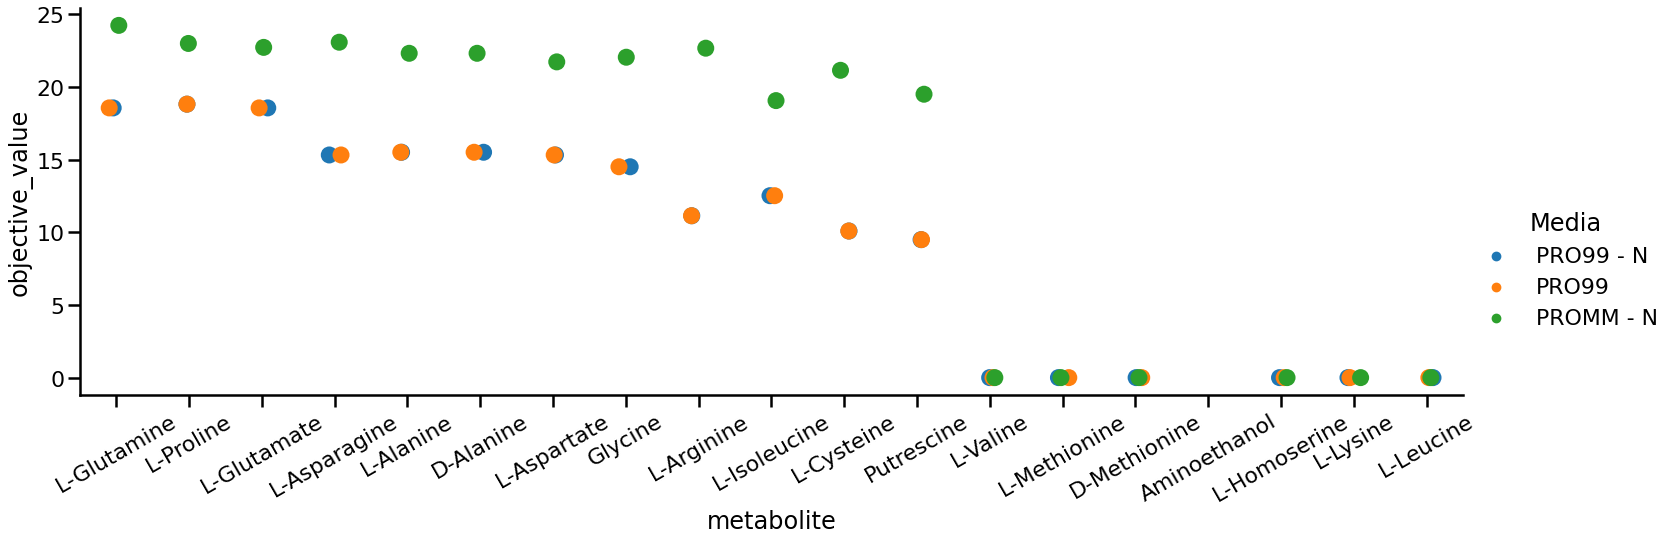

In [115]:
sns.set_context('poster')
sns.catplot(
    data=aa_df,
    x='metabolite', y='objective_value', hue='Media', 
    order=aa_order,
    aspect=3, s=17,#dodge=True,
    height=7
).set_xticklabels(rotation=30)

In [81]:
dna_df = df.loc[df.main.isin(['Nucleic acids'])].drop_duplicates(['uptake', 'Media'])

In [95]:
dna_order = dna_df.groupby('name').objective_value.mean().sort_values(ascending=False).index

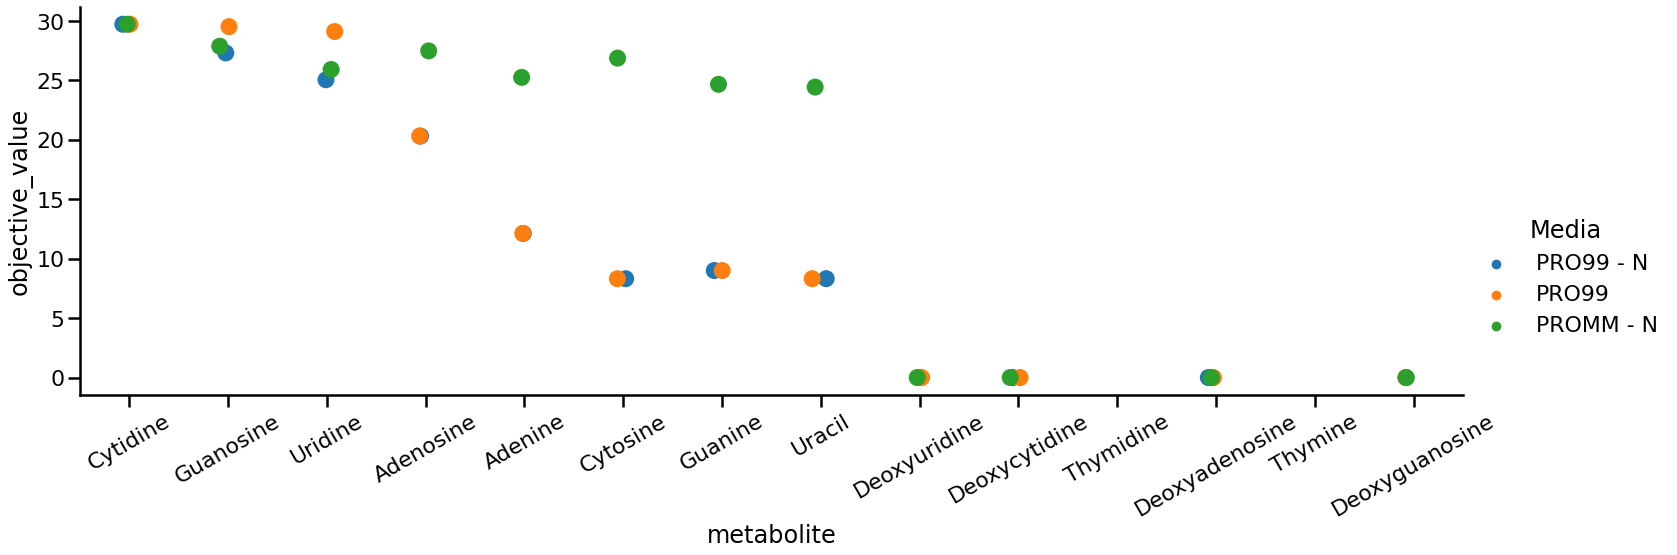

In [116]:
sns.set_context('poster')
sns.catplot(
    data=dna_df,
    order=dna_order,
    x='metabolite', y='objective_value', hue='Media', 
    aspect=3, s=17,#dodge=True,
    height=7
).set_xticklabels(rotation=30)

In [100]:
df_nodup = df.drop_duplicates(['uptake', 'Media', 'main'])

In [104]:
df_nodup.loc[df_nodup.main.isna(), 'main'] = 'Other'

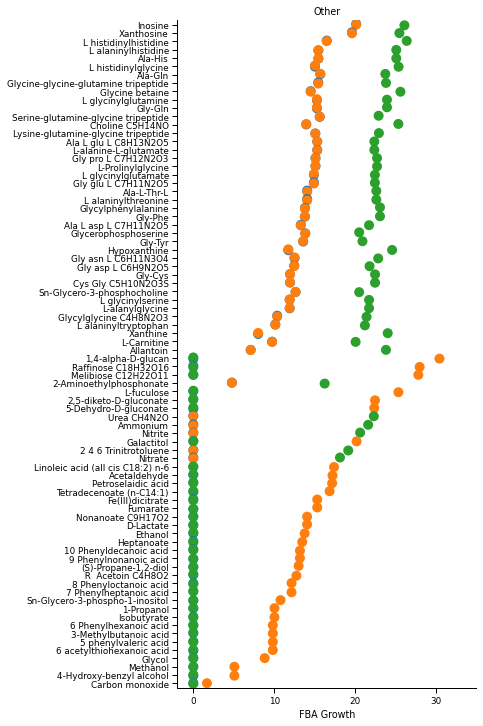

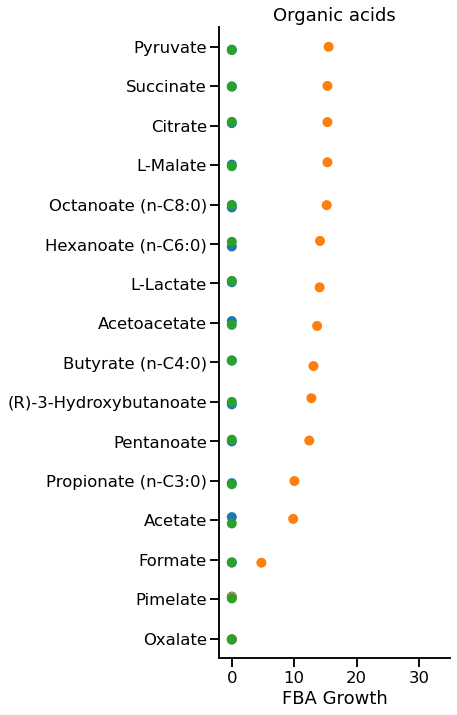

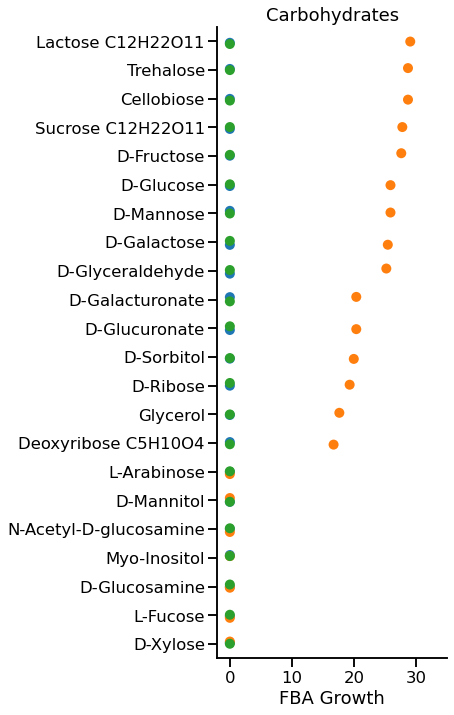

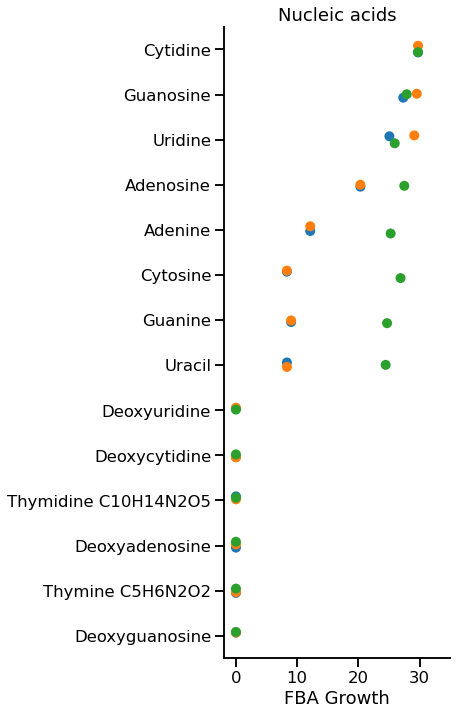

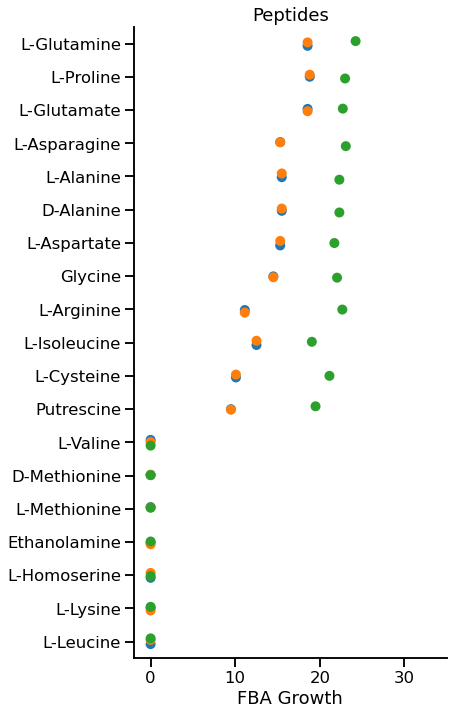

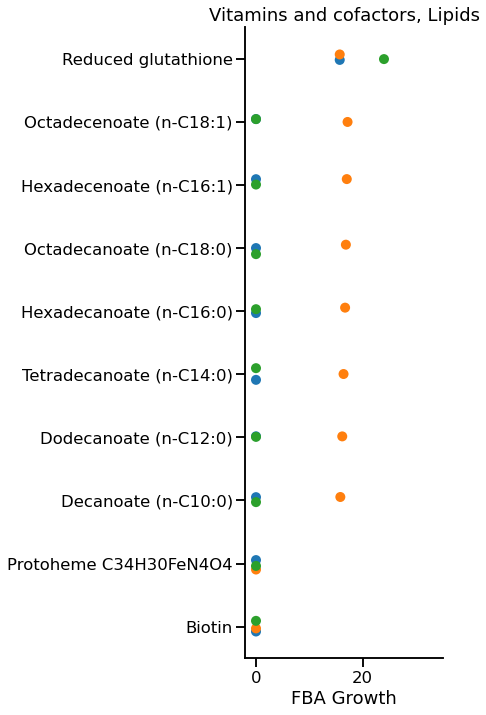

In [126]:
mainlist = [['Other'], ['Organic acids'], ['Carbohydrates'], ['Nucleic acids'], ['Peptides'],
       ['Vitamins and cofactors', 'Lipids']]
for c in mainlist:
    sns.set_context('talk')
    dfsel = df_nodup.loc[df_nodup.main.isin(c)]
    if 'Other' in c: 
        growing = dfsel.loc[dfsel.objective_value > 1e-5]         
        dfsel = dfsel.loc[dfsel.uptake.isin(growing['uptake'])]
        sns.set_context('paper')
        
        
    ordersel = dfsel.groupby('metabolite').objective_value.mean().sort_values(ascending=False).index    
    sns.catplot(
        data=dfsel,
        order=ordersel,
        y='metabolite', x='objective_value', hue='Media', 
        legend=False,
        aspect=0.7, s=10,#dodge=True,
        height=10
    ).set(title=', '.join(c), xlim=(-2,35), ylabel='', xlabel='FBA Growth')

In [127]:
df.head()

,uptake,objective_value,Media,reaction,metabolite,mid,N,C,BiggID,name,kegg_id,main,formula,aliases
0,EX_12ppd__R_e,-4.887372e-14,PRO99 - N,EX_12ppd__R_e,"(R)-Propane-1,2-diol",12ppd__R_e,False,True,12ppd__R,"(R)-1,2-Propanediol",C02912,NaN,C3H8O2,"Name: (R)-1,2-Propanediol; (R)-Propane-1,2-dio..."
1,EX_12ppd__R_e,-4.887372e-14,PRO99 - N,EX_12ppd__R_e,"(R)-Propane-1,2-diol",12ppd__R_e,False,True,12ppd__R,"(R)-1,2-Propanediol",C02912,NaN,C3H8O2,"Name: (R)-1,2-Propanediol; (R)-Propane-1,2-dio..."
2,EX_12ppd__R_e,-4.887372e-14,PRO99 - N,EX_12ppd__R_e,"(R)-Propane-1,2-diol",12ppd__R_e,False,True,12ppd__R,"(R)-1,2-Propanediol",C02912,NaN,C3H8O2,"Name: (R)-1,2-Propanediol; (R)-Propane-1,2-dio..."
3,EX_12ppd__R_e,3.339095e-13,PRO99,EX_12ppd__R_e,"(R)-Propane-1,2-diol",12ppd__R_e,False,True,12ppd__R,"(R)-1,2-Propanediol",C02912,NaN,C3H8O2,"Name: (R)-1,2-Propanediol; (R)-Propane-1,2-dio..."
4,EX_12ppd__R_e,3.339095e-13,PRO99,EX_12ppd__R_e,"(R)-Propane-1,2-diol",12ppd__R_e,False,True,12ppd__R,"(R)-1,2-Propanediol",C02912,NaN,C3H8O2,"Name: (R)-1,2-Propanediol; (R)-Propane-1,2-dio..."


In [130]:
df_nodup.loc[df_nodup.N & df_nodup.C, 'N/C'] = 'N+C'
df_nodup.loc[df_nodup.N & ~df_nodup.C, 'N/C'] = 'N'
df_nodup.loc[~df_nodup.N & df_nodup.C, 'N/C'] = 'C'
df_nodup.loc[~df_nodup.N & ~df_nodup.C, 'N/C'] = 'None'



C:\Users\Osnat\AppData\Local\Temp\ipykernel_15280\3598328156.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodup.loc[df_nodup.N & df_nodup.C, 'N/C'] = 'N+C'


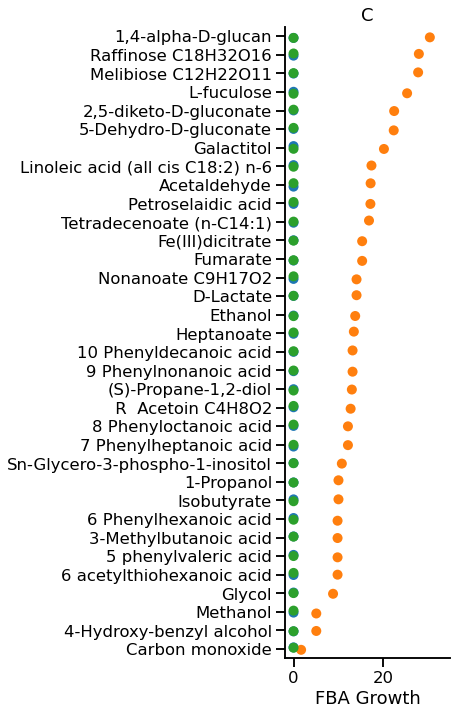

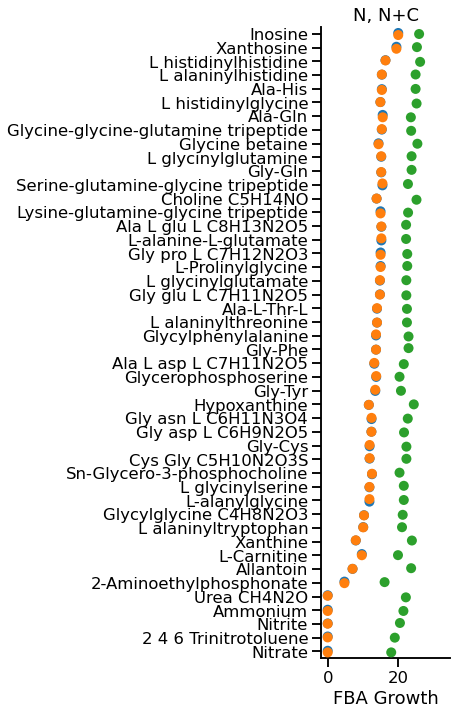

In [137]:
mainlist = [['Other'], ]
for c in mainlist:
    for nc in [['C'], ['N', 'N+C']]:
        sns.set_context('talk')
        dfsel = df_nodup.loc[df_nodup.main.isin(c) & df_nodup['N/C'].isin(nc)]
        if 'Other' in c: 
            growing = dfsel.loc[dfsel.objective_value > 1e-5]         
            dfsel = dfsel.loc[dfsel.uptake.isin(growing['uptake'])]
            #sns.set_context('paper')


        ordersel = dfsel.groupby('metabolite').objective_value.mean().sort_values(ascending=False).index    
        sns.catplot(
            data=dfsel,
            order=ordersel,
            y='metabolite', x='objective_value', hue='Media', 
            legend=False,
            aspect=0.7, s=10,#dodge=True,
            height=10
        ).set(title=', '.join(nc), xlim=(-2,35), ylabel='', xlabel='FBA Growth')

C:\Users\Osnat\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Osnat\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Osnat\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Osnat\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Osnat\anaconda3\lib

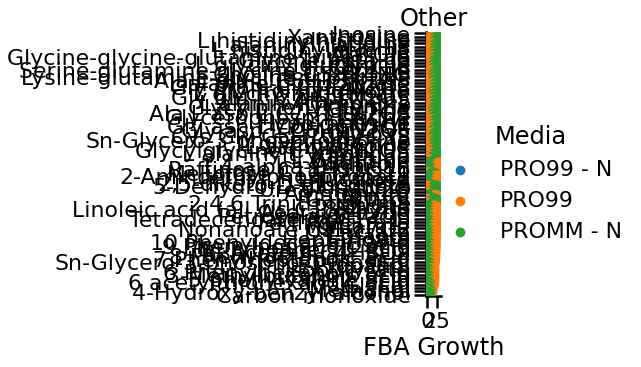

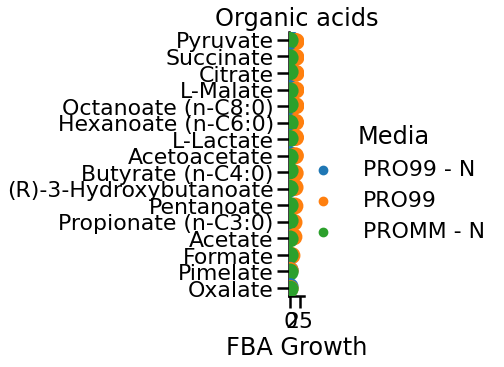

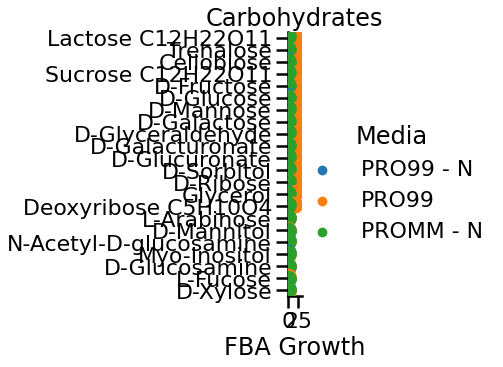

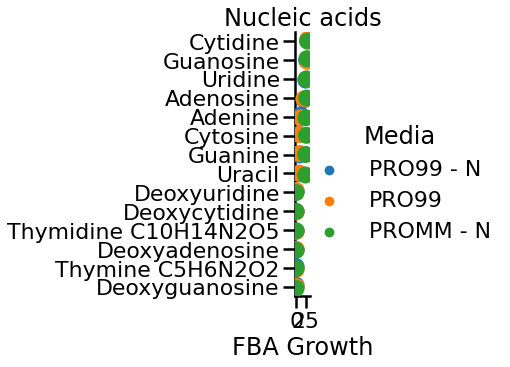

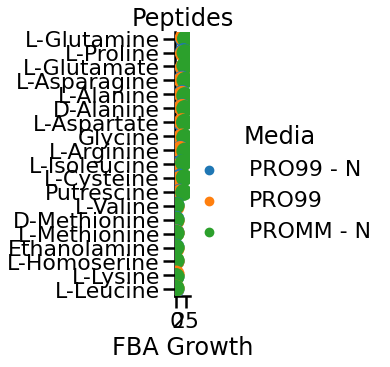

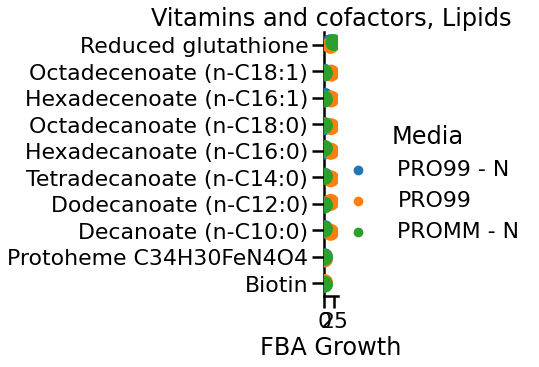

In [121]:
sns.set_context('poster')
mainlist = [['Other'], ['Organic acids'], ['Carbohydrates'], ['Nucleic acids'], ['Peptides'],
       ['Vitamins and cofactors', 'Lipids']]
for c in mainlist:
    dfsel = df_nodup.loc[df_nodup.main.isin(c)]
    if 'Other' in c: 
        growing = dfsel.loc[dfsel.objective_value > 1e-5]         
        dfsel = dfsel.loc[dfsel.uptake.isin(growing['uptake'])]
        
    ordersel = dfsel.groupby('metabolite').objective_value.mean().sort_values(ascending=False).index    
    sns.catplot(
        data=dfsel,
        order=ordersel,
        x='metabolite', x='objective_value', hue='Media', 
        facet_kws=dict(sharex=False),
        aspect=0.5, s=17,#dodge=True,
        #height=7
    ).set(title=', '.join(c), xlim=(-2,35), ylabel='', xlabel='FBA Growth')